<a href="https://colab.research.google.com/github/anjalinagel12/Deep-Learning-Projects-using-fast.ai/blob/master/food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Need v1.0.25 of fastai which is not yet published so install it from GitHub.

In [14]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==1.2

# For the latest nightly build:
#!pip install tf-nightly


Name: tensorflow
Version: 1.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, wheel, keras-applications, keras-preprocessing, tensorboard, astor, termcolor, six, tensorflow-estimator, protobuf, numpy, grpcio, gast
Required-by: stable-baselines, magenta, fancyimpute
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.13.1)


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [16]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [17]:
import torch
print(torch.__version__)
!pip install torchtext==0.2.3
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

1.0.0.dev20181206
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [36]:
!pip install fastai==1.0.46

    100% |████████████████████████████████| 194kB 6.6MB/s 
    100% |████████████████████████████████| 25.2MB 1.7MB/s 
    100% |████████████████████████████████| 1.9MB 9.8MB/s 
  Found existing installation: thinc 6.12.0
    Uninstalling thinc-6.12.0:
      Successfully uninstalled thinc-6.12.0
  Found existing installation: spacy 2.0.16
    Uninstalling spacy-2.0.16:
      Successfully uninstalled spacy-2.0.16
  Found existing installation: fastai 1.0.26
    Uninstalling fastai-1.0.26:
      Successfully uninstalled fastai-1.0.26


In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd 

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

##Food-101 dataset
The Food-101 dataset has 101 food categories, with 1000 images provided for each category for a total of 101,000 images. The Food-101 dataset provides a list of examples for training as well as another list for testing. Since the dataset specifies an equal amount of examples for each category, we do not need to worry about class imbalances. For each category, 250 images are in the test set and 750 for the training set. The training set is split into 20% for the validation set and 80% for the training set.

Training set: 60600 images
Validation set: 15150 images
Test set: 25250 images

The validation set is used to check the performance of the model after each training epoch. The test set is evaluated only once at the end of this notebook to provide a final accuracy score.

The examples for each category are located in subdirectories with the category names. The file list is treated like a csv file, though now delimited with a '/' symbol. This is read using Pandas into a Pandas DataFrame structure and then is modified so that the paths and .jpg file extensions are added. Fast AI provides a way of reading the DataFrame structure and indicating that the labels are in column 0 and the examples are in column 1.

The images are resized to 224x224 for faster training of the model. Data augmentation during training uses the default set of transforms provided by the Fast AI library as well as the default parameters. These are provided by the get_transforms() method. Since it's difficult to see what parameters and transforms are used from this method, the extracted list and parameters are provided below(ds_tfms). The pixel values of the examples are also normalized based on the ImageNet values. These examples could have been normalized by determining the mean & standard deviation of this specific dataset, but it appears that the ImageNet values were sufficient for a good result.

## Looking at the data

###Getting Dataset from Kaggle

In [21]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"anjalichoudhary12","key":"f7784c044bf5dda88882c6f7dc1752f5"}'> ~/.kaggle/kaggle.json  # Replace
!chmod 600 kaggle.json


chmod: cannot access 'kaggle.json': No such file or directory


In [22]:
!mkdir -p data
!kaggle datasets download -d dansbecker/food-101

401 - Unauthorized


In [24]:
!unzip food-101.zip -d data


Archive:  food-101.zip
replace data/food-101.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
path = Path('data/food-101') #untar creates food-101 subdirectory
path_img = path/'images'


###Loading and Understanding the Data
The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data, means **understanding how the data directories are structured**, what the **labels** are and what some **sample images** look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, **101 labels**are stored based on the folders.

Fortunately, the fastai library has a handy function made exactly for this.

[Image data from CSV / DataFrame](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_csv).

##Loading Labels 

(https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L108)

from_folder(path:PathOrStr, train:PathOrStr='train', valid:PathOrStr='valid', valid_pct=None, classes:Collection=None, kwargs:Any) → ImageDataBunch

Create from imagenet style dataset in path with train,valid,test subfolders (or provide valid_pct).

"Imagenet-style" datasets look something like this (note that the test folder is optional):

###loading from .txt file

In [0]:
train_path = 'data/food-101/meta/train.txt'
test_path = 'data/food-101/meta/test.txt'

###creating dataframe

In [0]:
def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

In [0]:
train_df = filelist2df(train_path)
test_df = filelist2df(test_path)


##Data transformation

In [0]:
ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])


In [33]:
!pip install -c fastai fastai

Could not open requirements file: [Errno 2] No such file or directory: 'fastai'


In [0]:
data = (ImageItemList.from_df(df=train_df, path=path/'images', cols=1)
        .random_split_by_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


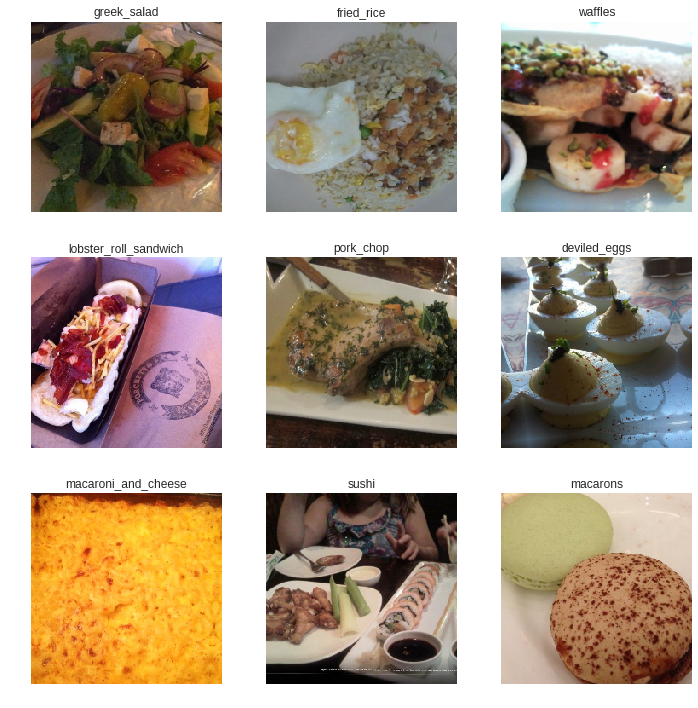

In [39]:
data.show_batch(rows=3, figsize=(10, 10))

Show one original image and then show several versions of that same image with the transformations applied. This helps to visualize what the transforms are doing.

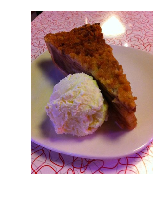

In [40]:
img = open_image('data/food-101/images/apple_pie/157083.jpg')
img.show()

In [0]:
img = open_image('data/food-101/images/apple_pie/157083.jpg')
img.show()

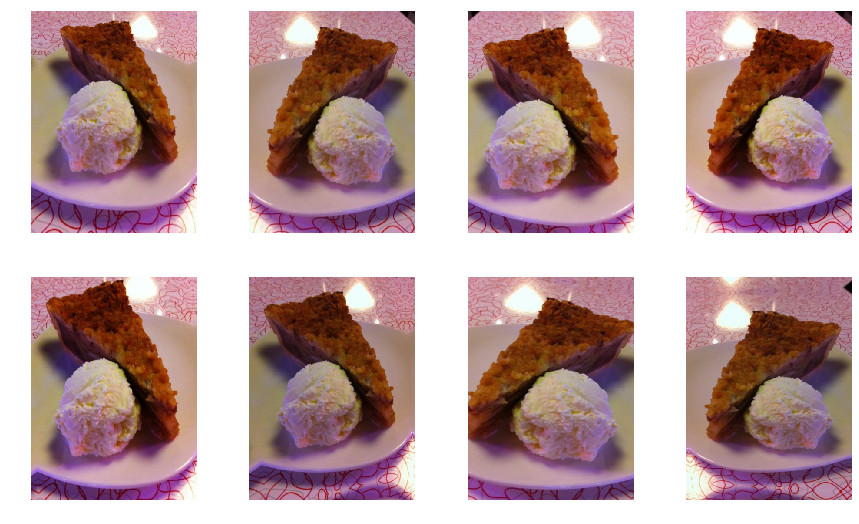

In [41]:
rows = 2
cols = 4
width = 15
height = 9


[img.apply_tfms(get_transforms()[0]).show(ax=ax) for i,ax in enumerate(plt.subplots(
    rows,cols,figsize=(width,height))[1].flatten())];

Here is a list of the classes. We verify that there are 101 classes.

In [42]:
print(data.classes);
print(data.c)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

##Training Model

###Data Metrics

For metrics, we will look at the accuracy(top-1) and the top-5 accuracy(notated as top_k_accuracy). ResNet-50 and the its weights are used as a starting point for transfer learning. ResNet-50 is selected as it is a fairly The Fast AI library then discards the classfication layer of the ResNet-50 model and then attaches a few additional layers. More information can be found in the fastai documentation



In [0]:
def top_k_accuracy(input:Tensor, targs:Tensor, k:int=5)->Rank0Tensor:
    "Computes the Top-k accuracy (target is in the top k predictions)."
    n = targs.shape[0]
    input = input.topk(k=k, dim=-1)[1].view(n, -1)
    targs = targs.view(n,-1)
    return (input == targs).sum(dim=1, dtype=torch.float32).mean()
    input = input.topk(k=k, dim=-1)[1]
    targs = targs.unsqueeze(dim=-1).expand_as(input)
    return (input == targs).max(dim=-1)[0].float().mean()


In [0]:
top_5 = partial(top_k_accuracy, k=5)



In [65]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, top_5], callback_fns=ShowGraph)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 80964720.13it/s]


###Learning rate analysis

Learning rate has a huge impact on training the model. If the learning rate is too large, the loss will diverge - if it is too small, then it will take a very long time to train the model. We use the fastai learning rate finder to see what is a good starting point for a learning rate. We look for the point of the greatest negative slope on the graph.

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


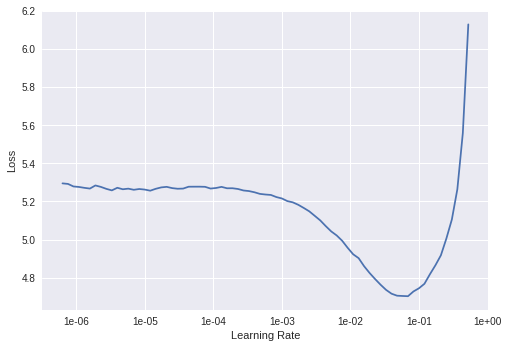

In [67]:
learn.recorder.plot()


We train the model for 5 epochs at a time, occasionally reducing the learning rate. We are training only the last few layers that was added for transfer learning. 

e,p,o,c,h,,,t,r,a,i,n,_,l,o,s,s,,,v,a,l,i,d,_,l,o,s,s,,,a,c,c,u,r,a,c,y,,,t,o,p,_,k,_,a,c,c,u,r,a,c,y
1,,,,,,,1,.,8,9,2,8,6,9,,,,,1,.,6,1,9,0,5,5,,,,,0,.,5,7,3,3,9,9,,,0,.,8,4,1,5,1,8,,,,,,
2,,,,,,,1,.,7,6,3,9,6,4,,,,,1,.,4,7,9,8,6,0,,,,,0,.,6,1,1,2,8,7,,,0,.,8,5,6,6,3,4,,,,,,
3,,,,,,,1,.,4,7,4,5,1,9,,,,,1,.,2,7,8,6,7,3,,,,,0,.,6,6,0,9,9,0,,,0,.,8,8,3,8,9,4,,,,,,
4,,,,,,,1,.,2,7,1,1,7,0,,,,,1,.,0,4,1,5,7,7,,,,,0,.,7,2,3,0,3,6,,,0,.,9,1,1,2,8,7,,,,,,
5,,,,,,,1,.,0,9,8,9,5,0,,,,,0,.,9,8,7,5,1,1,,,,,0,.,7,3,5,7,7,6,,,0,.,9,1,6,2,3,8,,,,,,


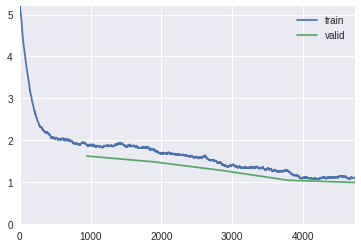

In [69]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))
learn.save('food-101-test-e5')


Let's unfreeze all the ResNet-50 weights and train them.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


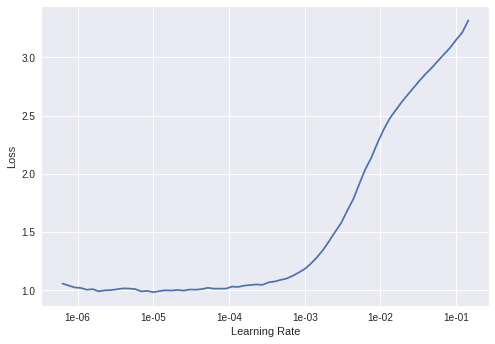

In [71]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

e,p,o,c,h,,,t,r,a,i,n,_,l,o,s,s,,,v,a,l,i,d,_,l,o,s,s,,,a,c,c,u,r,a,c,y,,,t,o,p,_,k,_,a,c,c,u,r,a,c,y
1,,,,,,,1,.,2,1,7,3,0,3,,,,,1,.,0,4,4,6,6,3,,,,,0,.,7,2,3,4,3,2,,,0,.,9,1,2,0,7,9,,,,,,
2,,,,,,,0,.,9,1,5,2,0,0,,,,,0,.,8,4,5,5,5,1,,,,,0,.,7,7,4,9,1,7,,,0,.,9,3,4,4,5,5,,,,,,


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff9573fd630>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff9573fd630>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", 

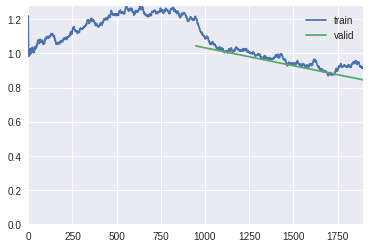

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff9573fd630>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff9573fd630>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", 

In [72]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-3))
learn.save('food-101-test-e10')

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e15')

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e20')

In [76]:
print("we save after weights are learned")
learn.save('stage-1-50')

we save after weights are learned


Let's see if full fine-tuning helps:

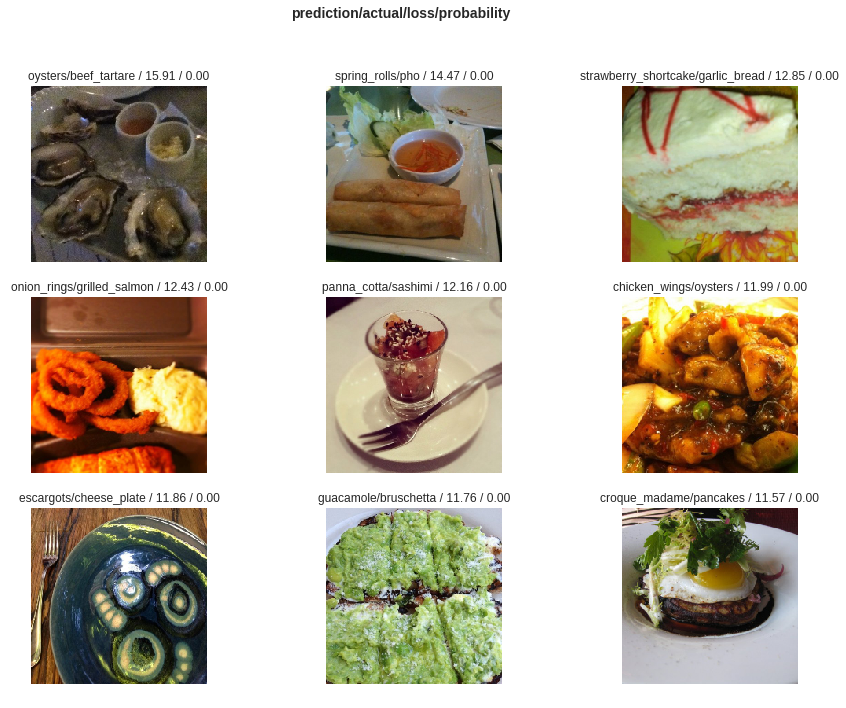

In [78]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability

In [79]:
interp.most_confused(min_val=5)

[('steak', 'filet_mignon', 26),
 ('filet_mignon', 'steak', 25),
 ('dumplings', 'gyoza', 21),
 ('beef_tartare', 'tuna_tartare', 19),
 ('prime_rib', 'steak', 19),
 ('tuna_tartare', 'beef_tartare', 19),
 ('tiramisu', 'chocolate_mousse', 16),
 ('apple_pie', 'bread_pudding', 15),
 ('cheesecake', 'strawberry_shortcake', 15),
 ('chocolate_mousse', 'chocolate_cake', 14),
 ('lobster_bisque', 'clam_chowder', 13),
 ('pork_chop', 'steak', 13),
 ('chocolate_cake', 'chocolate_mousse', 12),
 ('bread_pudding', 'apple_pie', 11),
 ('pork_chop', 'baby_back_ribs', 11),
 ('club_sandwich', 'grilled_cheese_sandwich', 10),
 ('fried_calamari', 'onion_rings', 10),
 ('greek_salad', 'beet_salad', 10),
 ('pork_chop', 'grilled_salmon', 10),
 ('ravioli', 'gnocchi', 10),
 ('ravioli', 'lasagna', 10),
 ('chocolate_mousse', 'ice_cream', 9),
 ('donuts', 'beignets', 9),
 ('panna_cotta', 'cheesecake', 9),
 ('pho', 'ramen', 9),
 ('pork_chop', 'filet_mignon', 9),
 ('poutine', 'french_fries', 9),
 ('pulled_pork_sandwich', 'ha

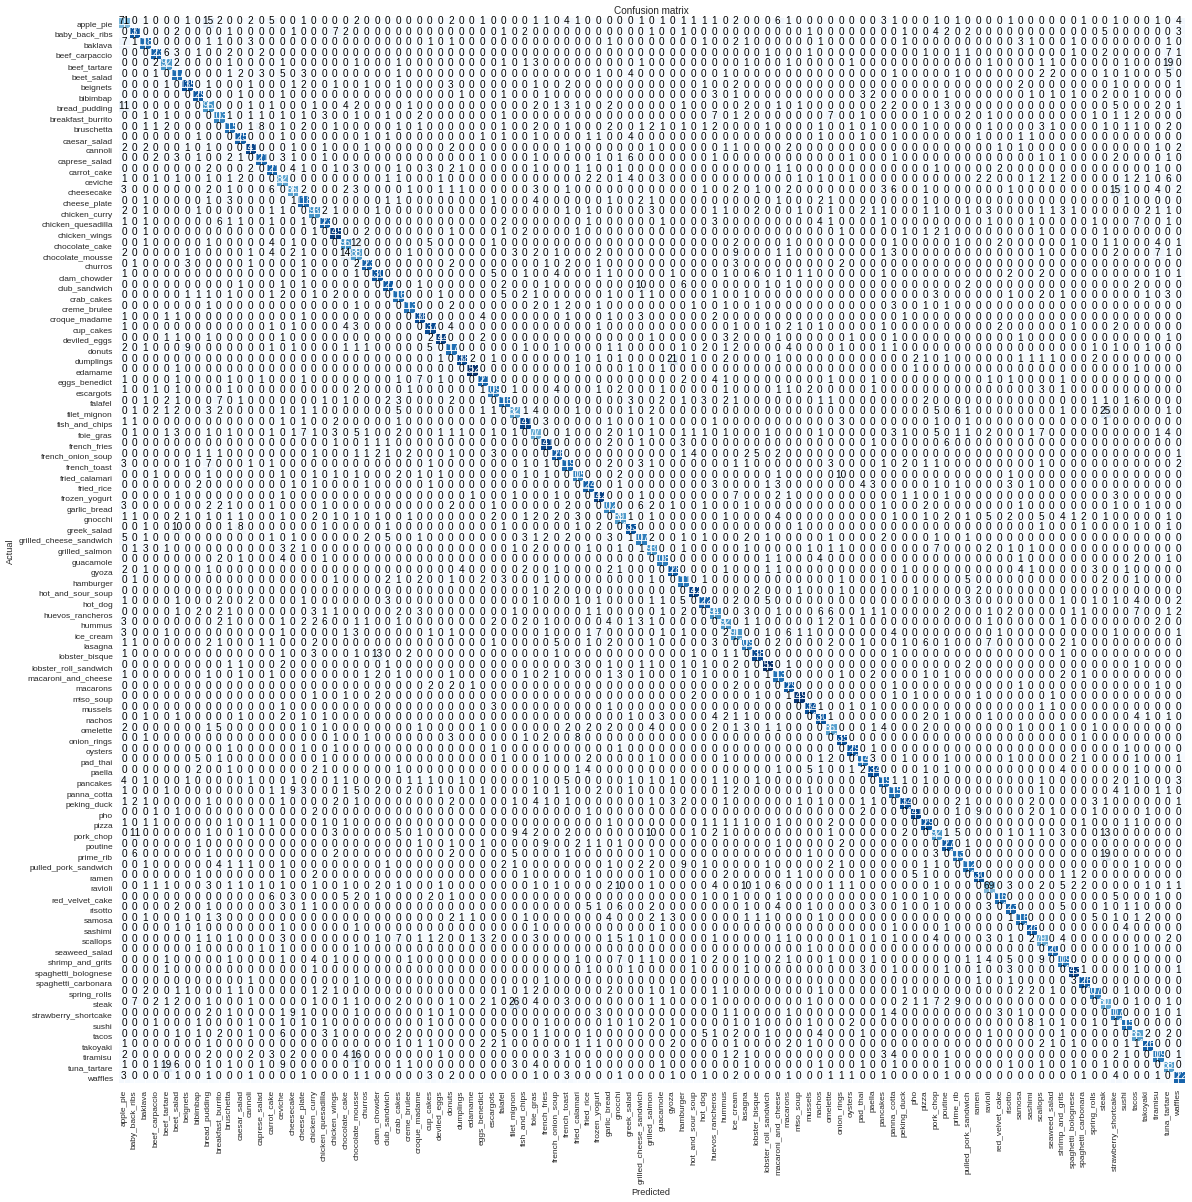

In [81]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)



---



##Start the Prediction

###Test data

Let's load the test set and evaluate using the model.

In [0]:
bs=16



test_data = (ImageItemList.from_df(df=test_df, path=path/'images', cols=1)
        .random_split_by_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


In [0]:
learn = create_cnn(test_data, models.resnet50, metrics=[accuracy, top_5], callback_fns=ShowGraph)


In [91]:
learn.load('food-101-test-e10')


Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (20200 items)
[Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie]...
Path: .
x: ImageItemList (20200 items)
[Image (3, 512, 512), Image (3, 512, 384), Image (3, 512, 384), Image (3, 512, 382), Image (3, 342, 512)]...
Path: data/food-101/images;
Valid: LabelList
y: CategoryList (5050 items)
[Category donuts, Category bread_pudding, Category mussels, Category poutine, Category samosa]...
Path: .
x: ImageItemList (5050 items)
[Image (3, 289, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 511), Image (3, 512, 512)]...
Path: data/food-101/images;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=F

In [92]:
learn.validate(test_data.train_dl)

[0.6728885, tensor(0.8112), tensor(0.9585)]